In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
import time
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
import numpy as np
import argparse
import os

from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Data Normalizers

In [2]:
#Define labels and our dataframe

data = pd.DataFrame(columns=['image_path', 'label'])
labels = {
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithMask' : 'WithMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask' : 'WithMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithMask' : 'WithMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test/WithoutMask' : 'NoMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask' : 'NoMask',
    '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask' : 'NoMask'
}

In [3]:
#Combining the training, test and validation sets into one dataframe

for folder in labels:
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        label = labels[folder]
        data = pd.concat([data, pd.DataFrame({'image_path': [image_path], 'label': [label]})], ignore_index=True)

In [4]:
#Save the dataframe containing the whole labeled dataset as a .csv file in the working directory

data.to_csv('dataset.csv')

In [5]:
#Reading the csv and converting it back to a dataframe

df = pd.read_csv("/kaggle/working/dataset.csv")
print(df)

       Unnamed: 0                                         image_path     label
0               0  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithMask
1               1  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithMask
2               2  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithMask
3               3  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithMask
4               4  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithMask
...           ...                                                ...       ...
11787       11787  /kaggle/input/face-mask-12k-images-dataset/Fac...    NoMask
11788       11788  /kaggle/input/face-mask-12k-images-dataset/Fac...    NoMask
11789       11789  /kaggle/input/face-mask-12k-images-dataset/Fac...    NoMask
11790       11790  /kaggle/input/face-mask-12k-images-dataset/Fac...    NoMask
11791       11791  /kaggle/input/face-mask-12k-images-dataset/Fac...    NoMask

[11792 rows x 3 columns]


In [6]:
# Split into temporary set and testing set
temp_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Split the temporary set into training set and validation set (80-20)
train_df, val_df = train_test_split(temp_df, test_size=0.2, random_state=42)

In [7]:
Train_Normalized = ImageDataGenerator(rescale = 1./255.,rotation_range = 45, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)

Test_Normalized = ImageDataGenerator(rescale = 1.0/255.)

Validation_Normalized = ImageDataGenerator(rescale = 1.0/255.)

Importing and Normalizing the Dataset

**Resizing + Rescaling + Sharpening + Median Blur + Brightness/Contrast + Colors + Inverse Transform + Histogram Equalization (8 Enhancements)**

In [25]:
def preprocess_image1(image_path):
    img = cv2.imread(image_path)

    # Apply desired transformations using OpenCV functions
    
    # Resizing
    img = cv2.resize(img, (224, 224))  # Resize to match your model's input shape
    
    #Sharpening 
  
    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
  
    # Sharpen the image 
    img = cv2.filter2D(img, -1, kernel) 
  
    # Remove noise using a median filter 
    img = cv2.medianBlur(img, 11)

    # adjusting Brightness and contrast
    brightness = 10
    contrast = 2.3 
    img = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness)
    
    #Enhancing Colors
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    img[:, :, 0] = img[:, :, 0] * 0.7
    img[:, :, 1] = img[:, :, 1] * 1.5
    img[:, :, 2] = img[:, :, 2] * 0.5
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    
    # Inverse by subtracting from 255 
    img = 255 - img 
    
    # Convert the image to grayscale 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
    # Equalize the histogram 
    img = cv2.equalizeHist(img) 
    
    return img

**Resizing + Rescaling + Sharpening + Median Blur (4 Enhancements)**

In [8]:
def preprocess_image2(image_path):
    
    img = cv2.imread(image_path)

    # Apply desired transformations using OpenCV functions
    
    # Resizing
    img = cv2.resize(img, (224, 224))  # Resize to match your model's input shape
    
    #Sharpening 
  
    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
  
    # Sharpen the image 
    img = cv2.filter2D(img, -1, kernel) 
  
    # Remove noise using a median filter 
    img = cv2.medianBlur(img, 11)

    # adjusting Brightness and contrast
    brightness = 10
    contrast = 2.3 
    img = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness)
    
    #Enhancing Colors
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    img[:, :, 0] = img[:, :, 0] * 0.7
    img[:, :, 1] = img[:, :, 1] * 1.5
    img[:, :, 2] = img[:, :, 2] * 0.5
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    return img

**Resizing + Rescaling + Sharpening + Median Blur + Brightness/Contrast + Colors (6 Enhancements)**

In [18]:
def preprocess_image3(image_path):
    img = cv2.imread(image_path)

    # Apply desired transformations using OpenCV functions
    
    # Resizing
    img = cv2.resize(img, (224, 224))  # Resize to match your model's input shape
    
    #Sharpening 
  
    # Create the sharpening kernel 
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) 
  
    # Sharpen the image 
    img = cv2.filter2D(img, -1, kernel) 
  
    # Remove noise using a median filter 
    img = cv2.medianBlur(img, 11)

    # adjusting Brightness and contrast
    brightness = 10
    contrast = 2.3 
    img = cv2.addWeighted(img, contrast, np.zeros(img.shape, img.dtype), 0, brightness)
    
    #Enhancing Colors
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) 
    img[:, :, 0] = img[:, :, 0] * 0.7
    img[:, :, 1] = img[:, :, 1] * 1.5
    img[:, :, 2] = img[:, :, 2] * 0.5
    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    return img

In [9]:
train_gen = Train_Normalized.flow_from_dataframe(dataframe=train_df, x_col='image_path', y_col='label', target_size = (224,224), class_mode = 'categorical',  color_mode= 'rgb', batch_size = 64, preprocess_function=preprocess_image2)

val_gen = Validation_Normalized.flow_from_dataframe(dataframe=val_df, x_col='image_path', y_col='label', target_size=(224,224), class_mode='categorical', color_mode= 'rgb', batch_size= 64)

test_gen = Test_Normalized.flow_from_dataframe(dataframe=test_df, x_col='image_path', y_col='label', target_size = (224,224), class_mode = 'categorical',color_mode= 'rgb', batch_size = 64)

Found 7075 validated image filenames belonging to 2 classes.
Found 1769 validated image filenames belonging to 2 classes.
Found 2948 validated image filenames belonging to 2 classes.


In [19]:
train_gen2 = Train_Normalized.flow_from_dataframe(dataframe=train_df, x_col='image_path', y_col='label', target_size = (224,224), class_mode = 'categorical',  color_mode= 'rgb', batch_size = 64, preprocess_function=preprocess_image3)

Found 7075 validated image filenames belonging to 2 classes.


In [26]:
train_gen3 = Train_Normalized.flow_from_dataframe(dataframe=train_df, x_col='image_path', y_col='label', target_size = (224,224), class_mode = 'categorical',  color_mode= 'rgb', batch_size = 64, preprocess_function=preprocess_image1)

Found 7075 validated image filenames belonging to 2 classes.


In [32]:
train_gen0 = Train_Normalized.flow_from_dataframe(dataframe=train_df, x_col='image_path', y_col='label', target_size = (224,224), class_mode = 'categorical',  color_mode= 'rgb', batch_size = 64)


Found 7075 validated image filenames belonging to 2 classes.


In [10]:
strategy = tf.distribute.MirroredStrategy()

In [11]:
def build_model():
    baseModel=MobileNetV2(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))
    headModel=baseModel.output
    headModel=AveragePooling2D(pool_size=(7,7))(headModel)
    headModel=Flatten(name="flatten")(headModel)
    headModel=Dense(128,activation="relu")(headModel)
    headModel=Dropout(0.5)(headModel)
    headModel=Dense(2,activation="softmax")(headModel)
    model=Model(inputs=baseModel.input,outputs=headModel)
    for layer in baseModel.layers:
        layer.trainable=False
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
    return model

In [33]:
with strategy.scope():
    model0 = build_model()
    
model0.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [34]:
history0 = model0.fit(train_gen0, epochs=20, validation_data=val_gen, callbacks=[early_stop])

Epoch 1/20
111/111 [==============================] - 121s 1s/step - loss: 0.9978 - accuracy: 0.5635 - val_loss: 0.5460 - val_accuracy: 0.7337
Epoch 2/20
111/111 [==============================] - 112s 1s/step - loss: 0.6369 - accuracy: 0.6903 - val_loss: 0.3829 - val_accuracy: 0.8638
Epoch 3/20
111/111 [==============================] - 112s 1s/step - loss: 0.4628 - accuracy: 0.7787 - val_loss: 0.2968 - val_accuracy: 0.9096
Epoch 4/20
111/111 [==============================] - 113s 1s/step - loss: 0.3722 - accuracy: 0.8400 - val_loss: 0.2467 - val_accuracy: 0.9327
Epoch 5/20
111/111 [==============================] - 111s 996ms/step - loss: 0.3212 - accuracy: 0.8686 - val_loss: 0.2140 - val_accuracy: 0.9412
Epoch 6/20
111/111 [==============================] - 112s 1s/step - loss: 0.2831 - accuracy: 0.8840 - val_loss: 0.1916 - val_accuracy: 0.9463
Epoch 7/20
111/111 [==============================] - 112s 1s/step - loss: 0.2492 - accuracy: 0.8994 - val_loss: 0.1747 - val_accuracy: 0.9

In [35]:
results0 = model0.evaluate(test_gen, verbose=0)
print("Test Loss: "+str(results0[0]*100)+"%")
print("Test Accuracy: "+str(results0[1]*100)+"%")

Test Loss: 9.976964443922043%
Test Accuracy: 96.87923789024353%


**Results with no pre-processing**

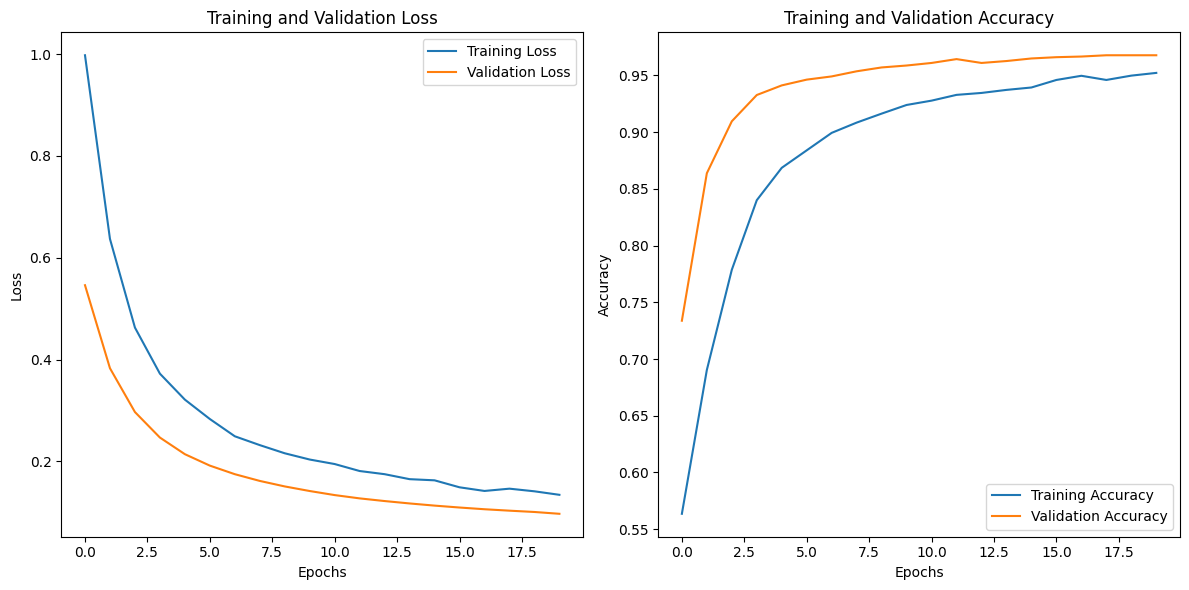

In [36]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss
ax1.plot(history0.history['loss'], label='Training Loss')
ax1.plot(history0.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot the accuracy
ax2.plot(history0.history['accuracy'], label='Training Accuracy')
ax2.plot(history0.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

# Adjust layout and show the plots
plt.tight_layout()

# Show the plots
plt.show()

In [37]:
model.save('/kaggle/working/model0.h5')

In [12]:
with strategy.scope():
    model = build_model()
    
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=2,restore_best_weights=True, verbose=1)
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stop])

Epoch 1/20
111/111 [==============================] - 162s 1s/step - loss: 0.8596 - accuracy: 0.5546 - val_loss: 0.5013 - val_accuracy: 0.7778
Epoch 2/20
111/111 [==============================] - 114s 1s/step - loss: 0.6033 - accuracy: 0.6953 - val_loss: 0.3600 - val_accuracy: 0.8802
Epoch 3/20
111/111 [==============================] - 113s 1s/step - loss: 0.4526 - accuracy: 0.7812 - val_loss: 0.2834 - val_accuracy: 0.9237
Epoch 4/20
111/111 [==============================] - 114s 1s/step - loss: 0.3507 - accuracy: 0.8476 - val_loss: 0.2346 - val_accuracy: 0.9356
Epoch 5/20
111/111 [==============================] - 114s 1s/step - loss: 0.2940 - accuracy: 0.8825 - val_loss: 0.2011 - val_accuracy: 0.9463
Epoch 6/20
111/111 [==============================] - 112s 1s/step - loss: 0.2659 - accuracy: 0.8912 - val_loss: 0.1770 - val_accuracy: 0.9536
Epoch 7/20
111/111 [==============================] - 112s 1s/step - loss: 0.2355 - accuracy: 0.9101 - val_loss: 0.1605 - val_accuracy: 0.9576

In [15]:
results = model.evaluate(test_gen, verbose=0)
print("Test Loss: "+str(results[0]*100)+"%")
print("Test Accuracy: "+str(results[1]*100)+"%")

Test Loss: 9.443500638008118%
Test Accuracy: 96.9131588935852%


**Model trained on Sharpening + Median Blur results**

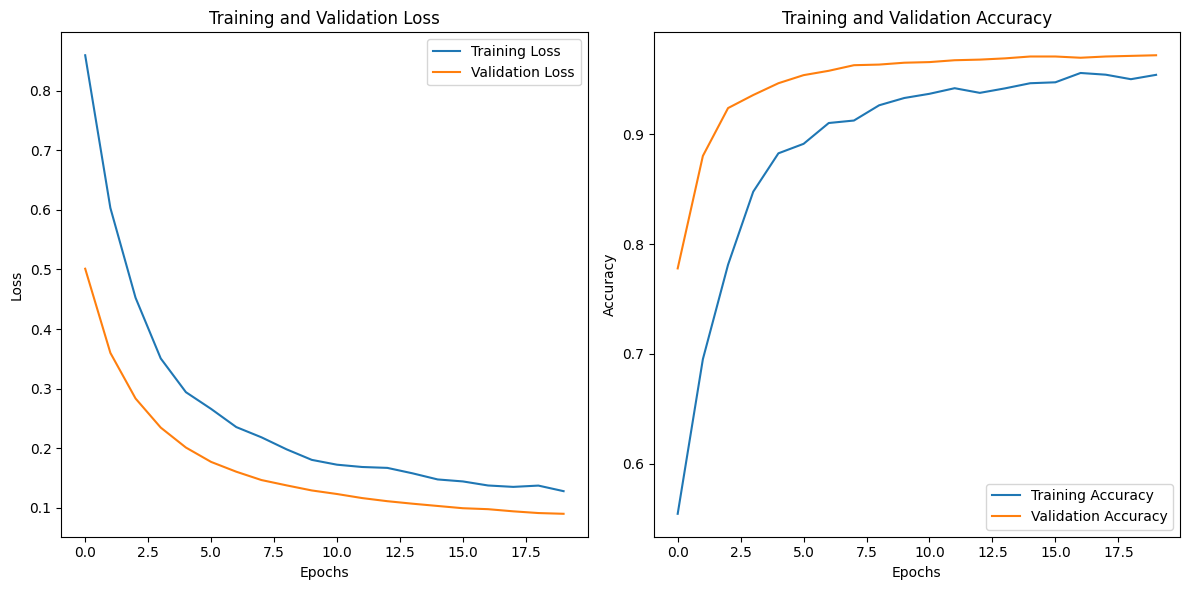

In [16]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot the accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

# Adjust layout and show the plots
plt.tight_layout()

# Show the plots
plt.show()

In [17]:
model.save('/kaggle/working/model1.h5')

In [20]:
with strategy.scope():
    model2 = build_model()
    
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [21]:
history2 = model2.fit(train_gen2, epochs=20, validation_data=val_gen, callbacks=[early_stop])

Epoch 1/20
111/111 [==============================] - 123s 1s/step - loss: 0.6188 - accuracy: 0.6746 - val_loss: 0.4559 - val_accuracy: 0.8208
Epoch 2/20
111/111 [==============================] - 113s 1s/step - loss: 0.4467 - accuracy: 0.7902 - val_loss: 0.3307 - val_accuracy: 0.8977
Epoch 3/20
111/111 [==============================] - 114s 1s/step - loss: 0.3552 - accuracy: 0.8488 - val_loss: 0.2613 - val_accuracy: 0.9259
Epoch 4/20
111/111 [==============================] - 113s 1s/step - loss: 0.3025 - accuracy: 0.8783 - val_loss: 0.2137 - val_accuracy: 0.9457
Epoch 5/20
111/111 [==============================] - 113s 1s/step - loss: 0.2691 - accuracy: 0.8879 - val_loss: 0.1850 - val_accuracy: 0.9531
Epoch 6/20
111/111 [==============================] - 113s 1s/step - loss: 0.2424 - accuracy: 0.9066 - val_loss: 0.1644 - val_accuracy: 0.9582
Epoch 7/20
111/111 [==============================] - 112s 1s/step - loss: 0.2226 - accuracy: 0.9141 - val_loss: 0.1481 - val_accuracy: 0.9610

In [22]:
results2 = model2.evaluate(test_gen, verbose=0)
print("Test Loss: "+str(results2[0]*100)+"%")
print("Test Accuracy: "+str(results2[1]*100)+"%")

Test Loss: 9.14195254445076%
Test Accuracy: 96.94707989692688%


**Model trained on Sharpening + Median Blur + Brightness/Contrast + Colors  results**

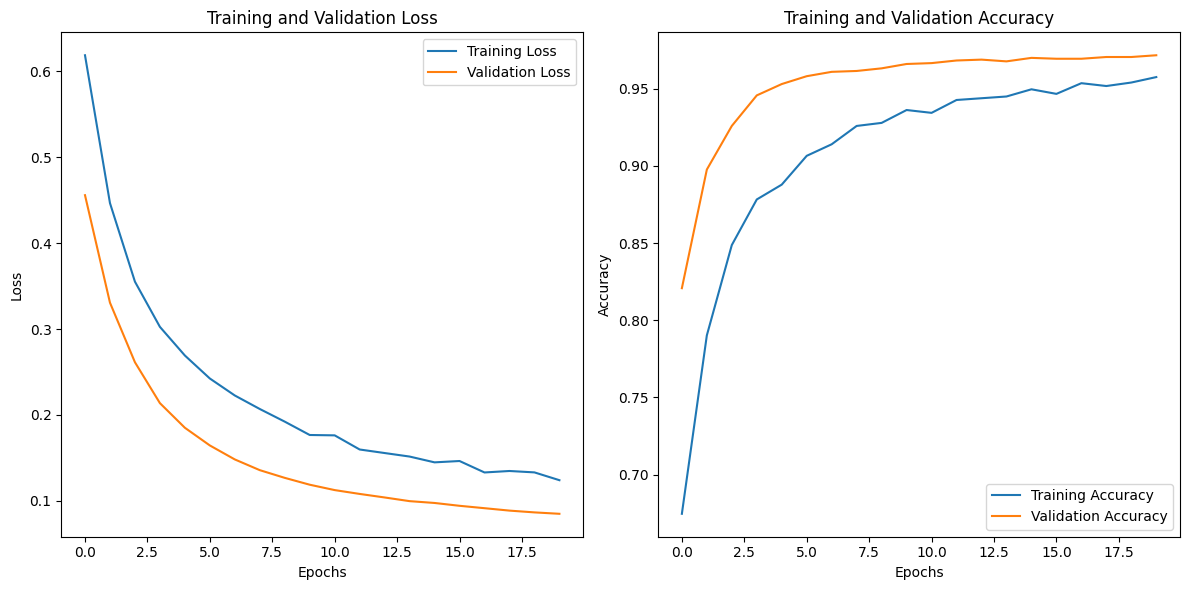

In [23]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss
ax1.plot(history2.history['loss'], label='Training Loss')
ax1.plot(history2.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot the accuracy
ax2.plot(history2.history['accuracy'], label='Training Accuracy')
ax2.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

# Adjust layout and show the plots
plt.tight_layout()

# Show the plots
plt.show()

In [24]:
model2.save('/kaggle/working/model2.h5')

In [27]:
with strategy.scope():
    model3 = build_model()
    
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [28]:
history3 = model3.fit(train_gen3, epochs=20, validation_data=val_gen, callbacks=[early_stop])

Epoch 1/20
111/111 [==============================] - 123s 1s/step - loss: 0.8433 - accuracy: 0.5823 - val_loss: 0.5709 - val_accuracy: 0.6659
Epoch 2/20
111/111 [==============================] - 112s 1s/step - loss: 0.5768 - accuracy: 0.7135 - val_loss: 0.3952 - val_accuracy: 0.8536
Epoch 3/20
111/111 [==============================] - 111s 1s/step - loss: 0.4303 - accuracy: 0.8031 - val_loss: 0.2930 - val_accuracy: 0.9276
Epoch 4/20
111/111 [==============================] - 112s 1s/step - loss: 0.3448 - accuracy: 0.8541 - val_loss: 0.2336 - val_accuracy: 0.9480
Epoch 5/20
111/111 [==============================] - 112s 1s/step - loss: 0.2954 - accuracy: 0.8766 - val_loss: 0.1977 - val_accuracy: 0.9553
Epoch 6/20
111/111 [==============================] - 113s 1s/step - loss: 0.2530 - accuracy: 0.9035 - val_loss: 0.1742 - val_accuracy: 0.9582
Epoch 7/20
111/111 [==============================] - 111s 999ms/step - loss: 0.2348 - accuracy: 0.9143 - val_loss: 0.1573 - val_accuracy: 0.9

In [29]:
results3 = model3.evaluate(test_gen, verbose=0)
print("Test Loss: "+str(results3[0]*100)+"%")
print("Test Accuracy: "+str(results3[1]*100)+"%")

Test Loss: 9.577561169862747%
Test Accuracy: 96.60786986351013%


**Model trained on Resizing + Rescaling + Sharpening + Median Blur + Brightness/Contrast + Colors + Inverse Transform + Histogram Equalization results**

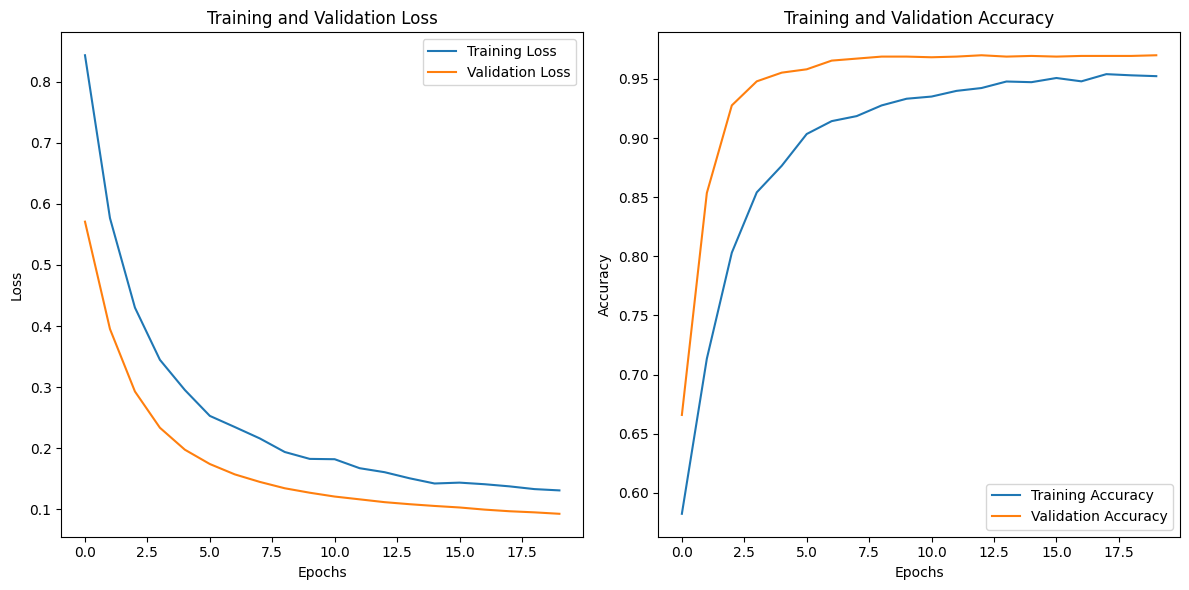

In [30]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the loss
ax1.plot(history3.history['loss'], label='Training Loss')
ax1.plot(history3.history['val_loss'], label='Validation Loss')
ax1.legend()
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')

# Plot the accuracy
ax2.plot(history3.history['accuracy'], label='Training Accuracy')
ax2.plot(history3.history['val_accuracy'], label='Validation Accuracy')
ax2.legend()
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')

# Adjust layout and show the plots
plt.tight_layout()

# Show the plots
plt.show()

In [31]:
model3.save('/kaggle/working/model3.h5')